In [1]:
import pandas as pd
import json
from datetime import datetime
import os

# Set the base directory
base_dir = r"C:\Users\tfeder\Documents\M2 CLASSES\Master Thesis\AAVE_Data\Questions\Messari\AAVE V2 Ethereum\markets"

# Get the most recent file
files = os.listdir(base_dir)
latest_file = max(files)

# Load the latest market data
with open(os.path.join(base_dir, latest_file), 'r') as f:
    market_data = json.load(f)

# Get the most recent date
latest_date = max(market_data.keys())

# Create a DataFrame with the latest market data
markets_df = pd.DataFrame(market_data[latest_date])

# Convert numeric columns from string to float
numeric_columns = ['totalValueLockedUSD', 'totalBorrowBalanceUSD', 'totalDepositBalanceUSD']
for col in numeric_columns:
    markets_df[col] = pd.to_numeric(markets_df[col], errors='coerce')

# Extract input token symbols
markets_df['input_token_symbol'] = markets_df['inputToken'].apply(lambda x: x['symbol'] if isinstance(x, dict) else None)

# Calculate and print some basic statistics
print(f"Number of markets: {len(markets_df)}")
print(f"Total TVL: ${markets_df['totalValueLockedUSD'].sum():,.2f}")
print(f"Total borrow balance: ${markets_df['totalBorrowBalanceUSD'].sum():,.2f}")
print(f"Total deposit balance: ${markets_df['totalDepositBalanceUSD'].sum():,.2f}")

# Sort markets by TVL and display top 5
print("\nTop 5 markets by TVL:")
top_markets = markets_df.sort_values('totalValueLockedUSD', ascending=False).head()
for _, market in top_markets.iterrows():
    print(f"{market['name']}: ${market['totalValueLockedUSD']:,.2f}")

# Calculate utilization rate (borrowed / TVL) for each market
markets_df['utilization_rate'] = markets_df['totalBorrowBalanceUSD'] / markets_df['totalValueLockedUSD']

print("\nTop 5 markets by utilization rate:")
for _, market in markets_df.sort_values('utilization_rate', ascending=False).head().iterrows():
    print(f"{market['name']}: {market['utilization_rate']:.2%}")

# Display interest rates
print("\nInterest rates for top 5 markets by TVL:")
for _, market in top_markets.iterrows():
    print(f"{market['name']}:")
    for rate in market['rates']:
        print(f"  {rate['side']} {rate['type']}: {float(rate['rate']):.2f}%")

# Calculate some additional statistics
print("\nAdditional Statistics:")
print(f"Average TVL per market: ${markets_df['totalValueLockedUSD'].mean():,.2f}")
print(f"Median TVL per market: ${markets_df['totalValueLockedUSD'].median():,.2f}")
print(f"Total number of unique input tokens: {markets_df['input_token_symbol'].nunique()}")

# Display top 10 input tokens by TVL
print("\nTop 10 input tokens by TVL:")
token_tvl = markets_df.groupby('input_token_symbol')['totalValueLockedUSD'].sum().sort_values(ascending=False)
for token, tvl in token_tvl.head(10).items():
    print(f"{token}: ${tvl:,.2f}")

Number of markets: 37
Total TVL: $3,139,774,667.66
Total borrow balance: $944,963,803.02
Total deposit balance: $3,139,774,667.66

Top 5 markets by TVL:
Aave interest bearing STETH: $964,454,540.42
Aave interest bearing WBTC: $722,776,472.89
Aave interest bearing WETH: $698,817,399.46
Aave interest bearing USDC: $323,982,202.15
Aave interest bearing USDT: $200,647,618.84

Top 5 markets by utilization rate:
Aave interest bearing RENFIL: 99.03%
Aave interest bearing USDC: 90.93%
Aave interest bearing FRAX: 85.18%
Aave interest bearing LUSD: 84.62%
Aave interest bearing DAI: 82.57%

Interest rates for top 5 markets by TVL:
Aave interest bearing STETH:
  BORROWER STABLE: 0.00%
  BORROWER VARIABLE: 0.00%
  LENDER VARIABLE: 0.00%
Aave interest bearing WBTC:
  BORROWER STABLE: 5.03%
  BORROWER VARIABLE: 0.81%
  LENDER VARIABLE: 0.08%
Aave interest bearing WETH:
  BORROWER STABLE: 5.11%
  BORROWER VARIABLE: 3.01%
  LENDER VARIABLE: 0.95%
Aave interest bearing USDC:
  BORROWER STABLE: 16.56%
  

Correlations between utilization rate and interest rates:
utilization_rate  utilization_rate  borrow_stable_rate  borrow_variable_rate  \
asset_category                                                                 
Major Crypto                   1.0            1.000000              1.000000   
Other Crypto                   1.0            0.173964             -0.163461   
Stablecoin                     1.0           -0.907781             -0.945178   

utilization_rate  lend_rate  
asset_category               
Major Crypto       1.000000  
Other Crypto       0.397220  
Stablecoin         0.540484  
Plot saved as 'utilization_vs_rates.png'

Average rates and utilization by asset category:
                utilization_rate  borrow_stable_rate  borrow_variable_rate  \
asset_category                                                               
Major Crypto            0.277054            5.070262              1.908834   
Other Crypto            0.201323            3.457505             2

""


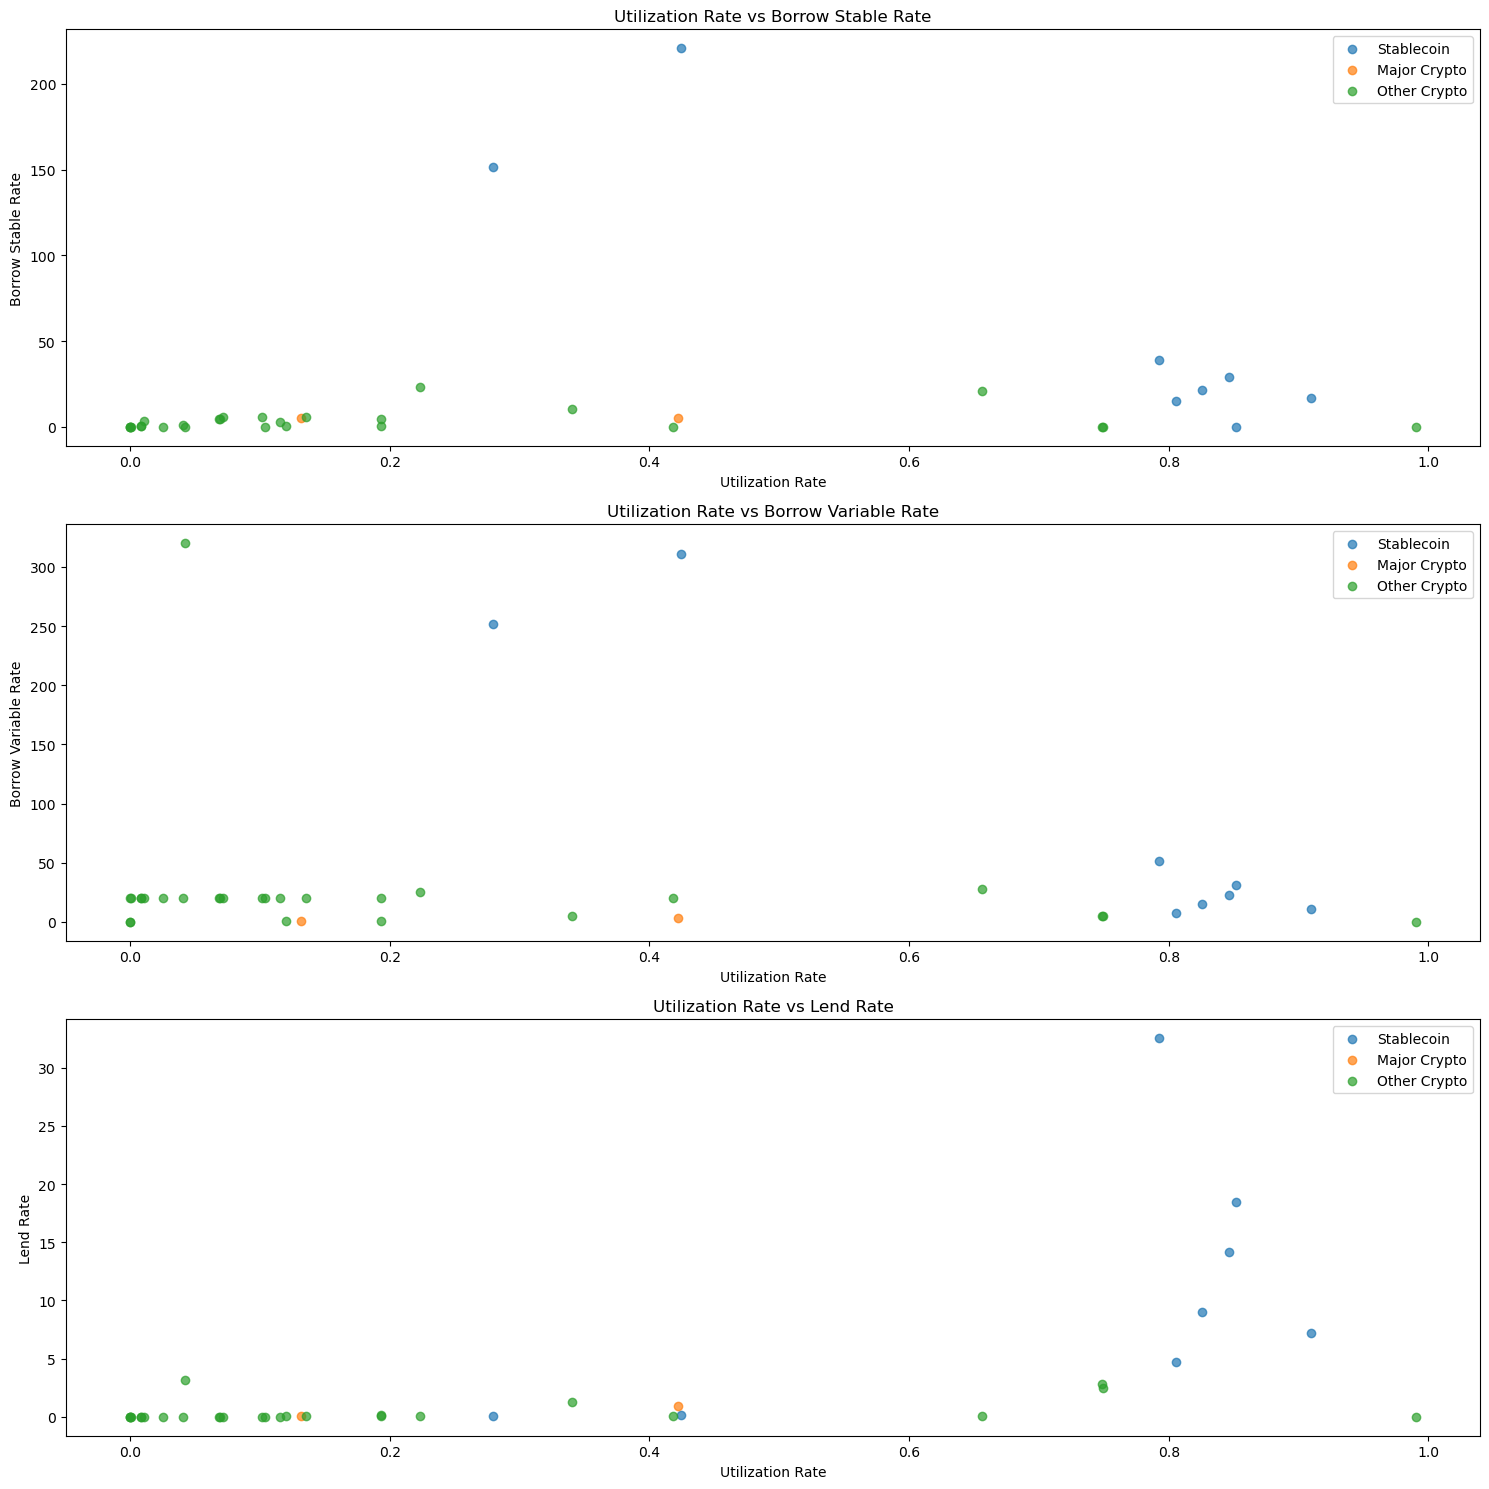

In [2]:
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set the base directory
base_dir = r"C:\Users\tfeder\Documents\M2 CLASSES\Master Thesis\AAVE_Data\Questions\Messari\AAVE V2 Ethereum\markets"

# Get the most recent file
files = os.listdir(base_dir)
latest_file = max(files)

# Load the latest market data
with open(os.path.join(base_dir, latest_file), 'r') as f:
    market_data = json.load(f)

# Get the most recent date
latest_date = max(market_data.keys())

# Create a DataFrame with the latest market data
markets_df = pd.DataFrame(market_data[latest_date])

# Convert numeric columns from string to float
numeric_columns = ['totalValueLockedUSD', 'totalBorrowBalanceUSD', 'totalDepositBalanceUSD']
for col in numeric_columns:
    markets_df[col] = pd.to_numeric(markets_df[col], errors='coerce')

# Calculate utilization rate
markets_df['utilization_rate'] = markets_df['totalBorrowBalanceUSD'] / markets_df['totalValueLockedUSD']

# Extract interest rates
markets_df['borrow_stable_rate'] = markets_df['rates'].apply(lambda x: next((float(rate['rate']) for rate in x if rate['side'] == 'BORROWER' and rate['type'] == 'STABLE'), None))
markets_df['borrow_variable_rate'] = markets_df['rates'].apply(lambda x: next((float(rate['rate']) for rate in x if rate['side'] == 'BORROWER' and rate['type'] == 'VARIABLE'), None))
markets_df['lend_rate'] = markets_df['rates'].apply(lambda x: next((float(rate['rate']) for rate in x if rate['side'] == 'LENDER'), None))

# Categorize assets
def categorize_asset(symbol):
    stablecoins = ['USDC', 'USDT', 'DAI', 'BUSD', 'TUSD', 'USDP', 'LUSD', 'GUSD', 'FRAX']
    if symbol in stablecoins:
        return 'Stablecoin'
    elif symbol in ['WBTC', 'WETH', 'ETH']:
        return 'Major Crypto'
    else:
        return 'Other Crypto'

markets_df['asset_category'] = markets_df['inputToken'].apply(lambda x: categorize_asset(x['symbol']))

# Calculate correlations
correlations = markets_df.groupby('asset_category').apply(lambda x: x[['utilization_rate', 'borrow_stable_rate', 'borrow_variable_rate', 'lend_rate']].corr().loc['utilization_rate'])

print("Correlations between utilization rate and interest rates:")
print(correlations)

# Plotting
plt.figure(figsize=(15, 15))

for i, rate_type in enumerate(['borrow_stable_rate', 'borrow_variable_rate', 'lend_rate']):
    plt.subplot(3, 1, i+1)
    for category in markets_df['asset_category'].unique():
        category_data = markets_df[markets_df['asset_category'] == category]
        plt.scatter(category_data['utilization_rate'], category_data[rate_type], label=category, alpha=0.7)
    
    plt.xlabel('Utilization Rate')
    plt.ylabel(rate_type.replace('_', ' ').title())
    plt.title(f'Utilization Rate vs {rate_type.replace("_", " ").title()}')
    plt.legend()

plt.tight_layout()
plt.savefig('utilization_vs_rates.png')
print("Plot saved as 'utilization_vs_rates.png'")

# Calculate average rates and utilization for each category
avg_rates = markets_df.groupby('asset_category')[['utilization_rate', 'borrow_stable_rate', 'borrow_variable_rate', 'lend_rate']].mean()
print("\nAverage rates and utilization by asset category:")
print(avg_rates)

# Identify outliers
def find_outliers(group):
    for col in ['utilization_rate', 'borrow_stable_rate', 'borrow_variable_rate', 'lend_rate']:
        z_scores = stats.zscore(group[col])
        outliers = group[abs(z_scores) > 2][['name', col]]
        if not outliers.empty:
            print(f"\nOutliers in {group.name} for {col}:")
            print(outliers)

markets_df.groupby('asset_category').apply(find_outliers)

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming we have the processed data in a DataFrame called 'markets_df'

# 1. Box plot of Utilization Rates by Asset Category
plt.figure(figsize=(10, 6))
sns.boxplot(x='asset_category', y='utilization_rate', data=markets_df)
plt.title('Distribution of Utilization Rates by Asset Category')
plt.xlabel('Asset Category')
plt.ylabel('Utilization Rate')
plt.savefig('utilization_rates_by_category.png')
plt.close()

# 2. Scatter plot of Utilization Rate vs Average Borrow Rate
markets_df['avg_borrow_rate'] = (markets_df['borrow_stable_rate'] + markets_df['borrow_variable_rate']) / 2
plt.figure(figsize=(10, 6))
for category in markets_df['asset_category'].unique():
    category_data = markets_df[markets_df['asset_category'] == category]
    plt.scatter(category_data['utilization_rate'], category_data['avg_borrow_rate'], label=category, alpha=0.7)
plt.title('Utilization Rate vs Average Borrow Rate')
plt.xlabel('Utilization Rate')
plt.ylabel('Average Borrow Rate (%)')
plt.legend()
plt.savefig('utilization_vs_avg_borrow_rate.png')
plt.close()

# 3. Bar plot of Average Rates by Asset Category
avg_rates = markets_df.groupby('asset_category')[['borrow_stable_rate', 'borrow_variable_rate', 'lend_rate']].mean()
avg_rates.plot(kind='bar', figsize=(10, 6))
plt.title('Average Rates by Asset Category')
plt.xlabel('Asset Category')
plt.ylabel('Rate (%)')
plt.legend(['Stable Borrow Rate', 'Variable Borrow Rate', 'Lend Rate'])
plt.savefig('average_rates_by_category.png')
plt.close()

# 4. (Optional) Heatmap of correlations between utilization and rates
correlation_data = markets_df.groupby('asset_category').apply(lambda x: x[['utilization_rate', 'borrow_stable_rate', 'borrow_variable_rate', 'lend_rate']].corr()['utilization_rate'])
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_data, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation of Utilization Rate with Interest Rates')
plt.savefig('utilization_rate_correlations.png')
plt.close()

print("Summary graphs have been saved as PNG files.")

Summary graphs have been saved as PNG files.


## Analysis

Certainly! Let's analyze the results of the Aave user behavior study:

Top 5 Markets by TVL:
The top markets are dominated by major cryptocurrencies (STETH, WBTC, WETH) and stablecoins (USDC, USDT). STETH (staked ETH) leads with nearly $1 billion in TVL, indicating strong interest in Ethereum staking within the Aave ecosystem.
User Composition:

Both (Lenders and Borrowers): 48.77%
Lender only: 48.06%
Borrower only: 3.17%

This distribution shows that most users engage in either lending or both lending and borrowing. Pure borrowers are relatively rare, suggesting that most borrowers also provide collateral or lend in other markets.
Average Positions per User Category:

Both: 14.98 positions
Lender: 10.42 positions
Borrower: 3.42 positions

Users who both lend and borrow are the most active, holding the highest number of positions on average. This indicates that these users are likely more experienced and engaged with the protocol.
Average Total Balance (USD) per User Category:

Both: $53,115,020
Lender: $29,817,110
Borrower: $365,541

Users who both lend and borrow have significantly higher average balances, suggesting they are likely larger investors or institutions. Pure borrowers have much smaller average balances.
Median Total Balance (USD) per User Category:

Borrower: $9,000
Both: $6,112
Lender: $1,173

Interestingly, the median balances show a different pattern from the averages. Pure borrowers have the highest median balance, indicating that while there are fewer of them, they tend to borrow larger amounts. The large difference between average and median balances suggests a skewed distribution with some very large users influencing the averages.
Top Markets User Behavior:

STETH: Primarily used as collateral, with over 23,000 users and a very high total balance.
WBTC: Used both for borrowing and as collateral, with more users using it as collateral.
USDC: High usage for both borrowing and collateral, with more users borrowing but larger amounts used as collateral.
USDT: Similar pattern to USDC, but with fewer users.
WETH: Widely used as collateral, with over 40,000 users, and also significant borrowing activity.


User Overlap Between Markets:

41,475 users are active in only one market
34,639 users are active in two markets
8,203 users are active in three markets
3,302 users are active in four markets
478 users are active in all five top markets

This shows that while many users stick to one or two markets, there's a significant number of users who diversify across multiple markets.

Key Insights:

The majority of users engage in lending or both lending and borrowing, with pure borrowers being a small minority.
Users who both lend and borrow are the most active and have the highest average balances, suggesting they are more experienced or institutional users.
There's a significant disparity between average and median balances, indicating the presence of some very large users or "whales" in the ecosystem.
Stablecoins (USDC, USDT) play a crucial role in both borrowing and collateral, while major cryptocurrencies (STETH, WBTC, WETH) are primarily used as collateral.
There's a good degree of user diversification across markets, with many users active in multiple markets.

These insights suggest a mature and diverse ecosystem within Aave, with users employing various strategies across different markets. The presence of large users alongside smaller ones indicates a mix of retail and potentially institutional participation.

In [5]:
positions_df.info()

NameError: name 'positions_df' is not defined

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better-looking graphs
plt.style.use('seaborn-v0_8')

def safe_plot(plot_func, filename):
    try:
        plt.figure(figsize=(12, 6))
        plot_func()
        plt.tight_layout()
        plt.savefig(filename)
        plt.close()
        print(f"Successfully generated and saved {filename}")
    except Exception as e:
        print(f"Error generating {filename}: {str(e)}")

# 1. User Composition Pie Chart
def plot_user_composition():
    user_composition = user_behavior['category'].value_counts()
    plt.pie(user_composition, labels=user_composition.index, autopct='%1.1f%%', startangle=90)
    plt.title('User Composition in Aave')
    plt.axis('equal')

safe_plot(plot_user_composition, 'user_composition.png')

# 2. Top 5 Markets by TVL Bar Chart
def plot_top_markets():
    sns.barplot(x='name', y='totalValueLockedUSD', data=top_markets)
    plt.title('Top 5 Aave Markets by Total Value Locked (TVL)')
    plt.xlabel('Market')
    plt.ylabel('TVL (USD)')
    plt.xticks(rotation=45, ha='right')

safe_plot(plot_top_markets, 'top_5_markets.png')

# 3. Average Balance by User Category (Log Scale)
def plot_avg_balance():
    sns.barplot(x=avg_balance.index, y=avg_balance.values)
    plt.title('Average Total Balance by User Category')
    plt.xlabel('User Category')
    plt.ylabel('Average Balance (USD, Log Scale)')
    plt.yscale('log')

safe_plot(plot_avg_balance, 'avg_balance.png')


print("Script execution completed.")

Error generating user_composition.png: name 'user_behavior' is not defined
Successfully generated and saved top_5_markets.png
Error generating avg_balance.png: name 'avg_balance' is not defined
Script execution completed.


<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8')

def safe_plot(plot_func, filename):
    try:
        plt.figure(figsize=(12, 6))
        plot_func()
        plt.tight_layout()
        plt.savefig(filename)
        plt.close()
        print(f"Successfully generated and saved {filename}")
    except Exception as e:
        print(f"Error generating {filename}: {str(e)}")

# Plots 1-3 remain the same...

# 4. User Activity Across Markets (Adjusted)
def plot_user_activity():
    market_count = user_market_presence.value_counts().sort_index()
    sns.barplot(x=market_count.index, y=market_count.values)
    plt.title('User Activity Across Multiple Markets')
    plt.xlabel('Number of Markets')
    plt.ylabel('Number of Users')
    plt.xticks(rotation=0)

safe_plot(plot_user_activity, 'user_activity.png')

# 5. Market Usage: Borrowing vs Collateral
def plot_market_usage():
    print("market_behavior shape:", market_behavior.shape)
    print("market_behavior head:")
    print(market_behavior.head())
    print("market_behavior columns:", market_behavior.columns)
    
    # Check if necessary columns exist
    required_columns = ['name', 'position_side', 'unique_users']
    if not all(col in market_behavior.columns for col in required_columns):
        print("Error: market_behavior is missing one or more required columns")
        return
    
    market_usage = market_behavior.pivot(index='name', columns='position_side', values='unique_users')
    print("market_usage shape:", market_usage.shape)
    print("market_usage head:")
    print(market_usage.head())
    
    market_usage.plot(kind='bar', stacked=True)
    plt.title('Market Usage: Borrowing vs Collateral')
    plt.xlabel('Market')
    plt.ylabel('Number of Users')
    plt.legend(title='Position Side')
    plt.xticks(rotation=45, ha='right')

safe_plot(plot_market_usage, 'market_usage.png')

print("Script execution completed.")

Error generating user_activity.png: name 'user_market_presence' is not defined
Error generating market_usage.png: name 'market_behavior' is not defined
Script execution completed.


<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [8]:
import pandas as pd
import json
import os
from datetime import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm
import threading
import time

# Set the base directory for market data
markets_dir = r"C:\Users\tfeder\Documents\M2 CLASSES\Master Thesis\AAVE_Data\Questions\Messari\AAVE V2 Ethereum\markets"

class TimeoutException(Exception):
    pass

def load_file_with_timeout(file_path, timeout=60):
    result = []
    
    def target():
        nonlocal result
        with open(file_path, 'r') as f:
            # Read the file in chunks
            chunk_size = 1024 * 1024  # 1MB chunks
            data = ""
            for chunk in iter(lambda: f.read(chunk_size), ""):
                data += chunk
                if len(data) > 100 * 1024 * 1024:  # If data exceeds 100MB, process it
                    partial_data = json.loads(data)
                    for date, markets in partial_data.items():
                        for market in markets:
                            market['date'] = date
                            result.append(market)
                    data = ""
            
            # Process any remaining data
            if data:
                partial_data = json.loads(data)
                for date, markets in partial_data.items():
                    for market in markets:
                        market['date'] = date
                        result.append(market)

    thread = threading.Thread(target=target)
    thread.start()
    thread.join(timeout)
    if thread.is_alive():
        raise TimeoutException(f"Processing {file_path} took too long")
    return result

def load_market_data(directory, timeout=300):  # Increased timeout to 5 minutes
    all_data = []
    files = sorted(os.listdir(directory))
    for file in tqdm(files, desc="Loading files"):
        if file.endswith('.json'):
            try:
                print(f"Processing file: {file}")
                start_time = time.time()
                file_path = os.path.join(directory, file)
                file_size = os.path.getsize(file_path) / (1024 * 1024)  # Size in MB
                print(f"File size: {file_size:.2f} MB")
                file_data = load_file_with_timeout(file_path, timeout)
                all_data.extend(file_data)
                processing_time = time.time() - start_time
                print(f"Finished processing {file} in {processing_time:.2f} seconds")
            except TimeoutException:
                print(f"Timeout occurred while processing {file}. Skipping this file.")
            except Exception as e:
                print(f"Error processing file {file}: {str(e)}")
                import traceback
                traceback.print_exc()

    return pd.DataFrame(all_data)

print("Loading market data...")
df = load_market_data(markets_dir)
print("Data loaded. Processing...")

# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])

# Function to extract rates
def extract_rates(rates):
    try:
        return {f"{rate['side']}_{rate['type']}": float(rate['rate']) for rate in rates}
    except Exception as e:
        print(f"Error extracting rates: {str(e)}")
        return {}

# Extract rates
print("Extracting rates...")
rate_data = df['rates'].apply(extract_rates).apply(pd.Series)
df = pd.concat([df, rate_data], axis=1)

# Define low rate threshold (e.g., 0.1%)
LOW_RATE_THRESHOLD = 0.1

# Identify instances of low or zero rates
print("Identifying low rates...")
low_rates = df[(df['LENDER_VARIABLE'] < LOW_RATE_THRESHOLD) | 
               (df['BORROWER_STABLE'] < LOW_RATE_THRESHOLD) | 
               (df['BORROWER_VARIABLE'] < LOW_RATE_THRESHOLD)]

# Summary of low rate occurrences
print("\nSummary of Low Interest Rate Occurrences:")
print(low_rates.groupby('name').size().sort_values(ascending=False))

# Detailed view of low rate instances (limit to top 10 for brevity)
print("\nDetailed view of Low Interest Rate Instances (Top 10):")
for _, row in low_rates.head(10).iterrows():
    print(f"Market: {row['name']}")
    print(f"Date: {row['date']}")
    print(f"Lender Variable Rate: {row.get('LENDER_VARIABLE', 'N/A')}%")
    print(f"Borrower Stable Rate: {row.get('BORROWER_STABLE', 'N/A')}%")
    print(f"Borrower Variable Rate: {row.get('BORROWER_VARIABLE', 'N/A')}%")
    print("---")

# Calculate the percentage of time each market had low rates
print("Calculating low rate percentages...")
total_observations = df.groupby('name').size()
low_rate_percentage = (low_rates.groupby('name').size() / total_observations * 100).sort_values(ascending=False)

print("\nPercentage of time markets had low interest rates:")
print(low_rate_percentage)

print("\nAnalysis complete.")

Loading market data...


Loading files:   0%|                                                                            | 0/38 [00:00<?, ?it/s]

Processing file: markets_2020-11-30.json
File size: 0.01 MB
Finished processing markets_2020-11-30.json in 0.02 seconds
Processing file: markets_2020-12-31.json
File size: 34.70 MB


Loading files:   5%|███▌                                                                | 2/38 [00:01<00:23,  1.51it/s]

Finished processing markets_2020-12-31.json in 1.30 seconds
Processing file: markets_2021-01-31.json
File size: 41.24 MB


Loading files:   8%|█████▎                                                              | 3/38 [00:02<00:37,  1.08s/it]

Finished processing markets_2021-01-31.json in 1.65 seconds
Processing file: markets_2021-02-28.json
File size: 40.18 MB


Loading files:  11%|███████▏                                                            | 4/38 [00:05<00:51,  1.52s/it]

Finished processing markets_2021-02-28.json in 2.25 seconds
Processing file: markets_2021-03-31.json
File size: 45.96 MB


Loading files:  13%|████████▉                                                           | 5/38 [00:08<01:04,  1.97s/it]

Finished processing markets_2021-03-31.json in 2.80 seconds
Processing file: markets_2021-04-30.json
File size: 45.09 MB


Loading files:  16%|██████████▋                                                         | 6/38 [00:15<01:58,  3.71s/it]

Finished processing markets_2021-04-30.json in 7.22 seconds
Processing file: markets_2021-05-31.json
File size: 49.78 MB


Loading files:  18%|████████████▌                                                       | 7/38 [00:17<01:41,  3.28s/it]

Finished processing markets_2021-05-31.json in 2.36 seconds
Processing file: markets_2021-06-30.json
File size: 48.99 MB


Loading files:  21%|██████████████▎                                                     | 8/38 [00:19<01:26,  2.90s/it]

Finished processing markets_2021-06-30.json in 2.06 seconds
Processing file: markets_2021-07-31.json
File size: 52.55 MB


Loading files:  24%|████████████████                                                    | 9/38 [00:22<01:24,  2.92s/it]

Finished processing markets_2021-07-31.json in 2.97 seconds
Processing file: markets_2021-08-31.json
File size: 55.86 MB


Loading files:  26%|█████████████████▋                                                 | 10/38 [00:27<01:37,  3.48s/it]

Finished processing markets_2021-08-31.json in 4.73 seconds
Processing file: markets_2021-09-30.json
File size: 58.06 MB


Loading files:  29%|███████████████████▍                                               | 11/38 [00:30<01:33,  3.46s/it]

Finished processing markets_2021-09-30.json in 3.42 seconds
Processing file: markets_2021-10-31.json
File size: 63.03 MB


Loading files:  32%|█████████████████████▏                                             | 12/38 [00:34<01:33,  3.58s/it]

Finished processing markets_2021-10-31.json in 3.87 seconds
Processing file: markets_2021-11-30.json
File size: 61.44 MB


Loading files:  34%|██████████████████████▉                                            | 13/38 [00:40<01:48,  4.36s/it]

Finished processing markets_2021-11-30.json in 6.14 seconds
Processing file: markets_2021-12-31.json
File size: 63.91 MB


Loading files:  37%|████████████████████████▋                                          | 14/38 [00:44<01:41,  4.24s/it]

Finished processing markets_2021-12-31.json in 3.95 seconds
Processing file: markets_2022-01-31.json
File size: 63.91 MB


Loading files:  39%|██████████████████████████▍                                        | 15/38 [00:48<01:32,  4.04s/it]

Finished processing markets_2022-01-31.json in 3.58 seconds
Processing file: markets_2022-02-28.json
File size: 57.80 MB


Loading files:  42%|████████████████████████████▏                                      | 16/38 [00:51<01:21,  3.69s/it]

Finished processing markets_2022-02-28.json in 2.87 seconds
Processing file: markets_2022-03-31.json
File size: 67.98 MB


Loading files:  45%|█████████████████████████████▉                                     | 17/38 [00:55<01:23,  3.99s/it]

Finished processing markets_2022-03-31.json in 4.69 seconds
Processing file: markets_2022-04-30.json
File size: 67.25 MB


Loading files:  47%|███████████████████████████████▋                                   | 18/38 [00:59<01:17,  3.86s/it]

Finished processing markets_2022-04-30.json in 3.54 seconds
Processing file: markets_2022-05-31.json
File size: 69.75 MB


Loading files:  50%|█████████████████████████████████▌                                 | 19/38 [01:02<01:11,  3.75s/it]

Finished processing markets_2022-05-31.json in 3.49 seconds
Processing file: markets_2022-06-30.json
File size: 68.41 MB


Loading files:  53%|███████████████████████████████████▎                               | 20/38 [01:10<01:28,  4.93s/it]

Finished processing markets_2022-06-30.json in 7.68 seconds
Processing file: markets_2022-07-31.json
File size: 71.73 MB


Loading files:  55%|█████████████████████████████████████                              | 21/38 [01:14<01:17,  4.57s/it]

Finished processing markets_2022-07-31.json in 3.74 seconds
Processing file: markets_2022-08-31.json
File size: 73.58 MB


Loading files:  58%|██████████████████████████████████████▊                            | 22/38 [01:18<01:09,  4.33s/it]

Finished processing markets_2022-08-31.json in 3.76 seconds
Processing file: markets_2022-09-30.json
File size: 72.95 MB


Loading files:  61%|████████████████████████████████████████▌                          | 23/38 [01:21<01:02,  4.17s/it]

Finished processing markets_2022-09-30.json in 3.79 seconds
Processing file: markets_2022-10-31.json
File size: 75.45 MB


Loading files:  63%|██████████████████████████████████████████▎                        | 24/38 [01:26<00:58,  4.17s/it]

Finished processing markets_2022-10-31.json in 4.18 seconds
Processing file: markets_2022-11-30.json
File size: 73.19 MB


Loading files:  66%|████████████████████████████████████████████                       | 25/38 [01:32<01:02,  4.83s/it]

Finished processing markets_2022-11-30.json in 6.37 seconds
Processing file: markets_2022-12-31.json
File size: 75.63 MB


Loading files:  68%|█████████████████████████████████████████████▊                     | 26/38 [01:38<01:01,  5.14s/it]

Finished processing markets_2022-12-31.json in 5.87 seconds
Processing file: markets_2023-01-31.json
File size: 75.62 MB


Loading files:  71%|███████████████████████████████████████████████▌                   | 27/38 [01:41<00:51,  4.67s/it]

Finished processing markets_2023-01-31.json in 3.57 seconds
Processing file: markets_2023-02-28.json
File size: 68.30 MB


Loading files:  74%|█████████████████████████████████████████████████▎                 | 28/38 [02:03<01:36,  9.61s/it]

Finished processing markets_2023-02-28.json in 21.11 seconds
Processing file: markets_2023-03-31.json
File size: 75.65 MB


Loading files:  76%|███████████████████████████████████████████████████▏               | 29/38 [02:08<01:14,  8.31s/it]

Finished processing markets_2023-03-31.json in 5.27 seconds
Processing file: markets_2023-04-30.json
File size: 73.24 MB


Loading files:  79%|████████████████████████████████████████████████████▉              | 30/38 [02:12<00:57,  7.18s/it]

Finished processing markets_2023-04-30.json in 4.56 seconds
Processing file: markets_2023-05-31.json
File size: 75.67 MB


Loading files:  82%|██████████████████████████████████████████████████████▋            | 31/38 [02:17<00:44,  6.39s/it]

Finished processing markets_2023-05-31.json in 4.55 seconds
Processing file: markets_2023-06-30.json
File size: 73.23 MB


Loading files:  84%|████████████████████████████████████████████████████████▍          | 32/38 [02:22<00:35,  5.86s/it]

Finished processing markets_2023-06-30.json in 4.60 seconds
Processing file: markets_2023-07-31.json
File size: 75.80 MB


Loading files:  87%|██████████████████████████████████████████████████████████▏        | 33/38 [02:28<00:30,  6.01s/it]

Finished processing markets_2023-07-31.json in 6.35 seconds
Processing file: markets_2023-08-31.json
File size: 75.93 MB


Loading files:  89%|███████████████████████████████████████████████████████████▉       | 34/38 [02:32<00:22,  5.50s/it]

Finished processing markets_2023-08-31.json in 4.32 seconds
Processing file: markets_2023-09-30.json
File size: 73.47 MB


Loading files:  92%|█████████████████████████████████████████████████████████████▋     | 35/38 [02:36<00:14,  4.95s/it]

Finished processing markets_2023-09-30.json in 3.66 seconds
Processing file: markets_2023-10-31.json
File size: 75.96 MB


Loading files:  95%|███████████████████████████████████████████████████████████████▍   | 36/38 [02:40<00:09,  4.71s/it]

Finished processing markets_2023-10-31.json in 4.14 seconds
Processing file: markets_2023-11-30.json
File size: 73.52 MB


Loading files:  97%|█████████████████████████████████████████████████████████████████▏ | 37/38 [02:45<00:04,  4.81s/it]

Finished processing markets_2023-11-30.json in 5.05 seconds
Processing file: markets_2023-12-31.json
File size: 75.86 MB


Loading files: 100%|███████████████████████████████████████████████████████████████████| 38/38 [03:44<00:00,  5.90s/it]

Finished processing markets_2023-12-31.json in 58.73 seconds


Data loaded. Processing...
Extracting rates...
Identifying low rates...

Summary of Low Interest Rate Occurrences:
name
Aave interest bearing AAVE      27009
Aave interest bearing SUSD      26986
Aave interest bearing SNX       26986
Aave interest bearing BUSD      25938
Aave interest bearing XSUSHI    25203
Aave interest bearing RENFIL    23508
Aave interest bearing ZRX       21781
Aave interest bearing AMPL      21364
Aave interest bearing PAX       21324
Aave interest bearing DPI       20694
Aave interest bearing UNI       20638
Aave interest bearing MKR       20240
Aave interest bearing FRAX      20185
Aave interest bearing WBTC      19206
Aave interest bearing ENJ       16814
Aave interest bearing REN       16272
Aave interest bearing STETH     16135
Aave interest bearing ENS       15953
Aave interest bearing YFI       15227
Aave interest bearing MANA      14811
Aave interest bearing 1INCH     12443
Aave interest bearing LINK      12207
Aave interest bearing UST        9894
Aave i

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

def to_numeric_safe(s):
    return pd.to_numeric(s, errors='coerce')

def clean_dataframe(df):
    # Explicitly list columns that should be numeric
    numeric_columns = ['LENDER_VARIABLE', 'BORROWER_STABLE', 'BORROWER_VARIABLE', 
                       'totalBorrowBalanceUSD', 'totalValueLockedUSD']
    
    for col in numeric_columns:
        if col in df.columns:
            df[col] = to_numeric_safe(df[col])
        else:
            print(f"Warning: Expected column '{col}' not found in dataframe")
    
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    
    # Drop rows where all numeric columns are NaN
    df = df.dropna(subset=numeric_columns, how='all')
    
    return df

def plot_interest_rates_over_time(df, asset):
    asset_data = df[df['name'] == f'Aave interest bearing {asset}']
    asset_data = clean_dataframe(asset_data)
    
    plt.figure(figsize=(15, 7))
    for col in ['LENDER_VARIABLE', 'BORROWER_STABLE', 'BORROWER_VARIABLE']:
        if col in asset_data.columns:
            plt.plot(asset_data['date'], asset_data[col], label=col)
    plt.title(f'Interest Rates Over Time for {asset}')
    plt.xlabel('Date')
    plt.ylabel('Interest Rate (%)')
    plt.legend()
    plt.yscale('log')
    plt.tight_layout()
    plt.savefig(f'{asset}_interest_rates_over_time.png')
    plt.close()

# Plot for key assets
key_assets = ['WETH', 'WBTC', 'USDC', 'DAI', 'AAVE']
for asset in key_assets:
    try:
        plot_interest_rates_over_time(df, asset)
        print(f"Successfully plotted interest rates for {asset}")
    except Exception as e:
        print(f"Error plotting interest rates for {asset}: {str(e)}")

# Prepare WETH data
weth_data = df[df['name'] == 'Aave interest bearing WETH'].copy()
weth_data = clean_dataframe(weth_data)
weth_data = weth_data.set_index('date')

print("WETH data columns:", weth_data.columns)
print("WETH data types:", weth_data.dtypes)
print("WETH data non-null counts:\n", weth_data.count())

# Fetch Ethereum price data
eth_price = yf.download('ETH-USD', start='2020-11-30', end='2023-12-31')

# Resample to daily frequency, only for numeric columns
numeric_columns = ['LENDER_VARIABLE', 'BORROWER_STABLE', 'BORROWER_VARIABLE', 
                   'totalBorrowBalanceUSD', 'totalValueLockedUSD']
weth_daily = weth_data[numeric_columns].resample('D').mean()

# Merge WETH data with ETH price
merged_data = pd.merge(weth_daily, eth_price['Close'], left_index=True, right_index=True, how='inner')
merged_data.columns = [*merged_data.columns[:-1], 'ETH_PRICE']

# Calculate correlations
correlation_columns = [col for col in ['LENDER_VARIABLE', 'BORROWER_STABLE', 'BORROWER_VARIABLE', 'ETH_PRICE'] if col in merged_data.columns]
correlations = merged_data[correlation_columns].corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlations, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation between WETH Interest Rates and ETH Price')
plt.tight_layout()
plt.savefig('WETH_ETH_correlation_heatmap.png')
plt.close()

def plot_utilization_vs_rates(df, asset):
    asset_data = df[df['name'] == f'Aave interest bearing {asset}'].copy()
    asset_data = clean_dataframe(asset_data)
    if 'totalBorrowBalanceUSD' in asset_data.columns and 'totalValueLockedUSD' in asset_data.columns:
        asset_data['utilization_rate'] = asset_data['totalBorrowBalanceUSD'] / asset_data['totalValueLockedUSD']
    else:
        print(f"Warning: Unable to calculate utilization rate for {asset}")
        return

    fig, axes = plt.subplots(3, 1, figsize=(15, 20))
    
    for ax, col in zip(axes, ['LENDER_VARIABLE', 'BORROWER_STABLE', 'BORROWER_VARIABLE']):
        if col in asset_data.columns:
            sns.scatterplot(data=asset_data, x='utilization_rate', y=col, ax=ax)
            ax.set_title(f'{asset} Utilization Rate vs {col}')
            ax.set_xlabel('Utilization Rate')
            ax.set_ylabel('Interest Rate (%)')
    
    plt.tight_layout()
    plt.savefig(f'{asset}_utilization_vs_rates.png')
    plt.close()

    # Calculate and print correlations
    correlation_columns = ['utilization_rate', 'LENDER_VARIABLE', 'BORROWER_STABLE', 'BORROWER_VARIABLE']
    correlation_columns = [col for col in correlation_columns if col in asset_data.columns]
    correlations = asset_data[correlation_columns].corr()['utilization_rate']
    print(f"\nCorrelations between Utilization Rate and Interest Rates for {asset}:")
    print(correlations)

# Analyze utilization vs rates for key assets
for asset in key_assets:
    try:
        plot_utilization_vs_rates(df, asset)
        print(f"Successfully plotted utilization vs rates for {asset}")
    except Exception as e:
        print(f"Error plotting utilization vs rates for {asset}: {str(e)}")

print("Analysis complete. Plots have been saved as PNG files.")

C:\Users\tfeder\AppData\Local\Temp\ipykernel_1972\239755794.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = to_numeric_safe(df[col])
C:\Users\tfeder\AppData\Local\Temp\ipykernel_1972\239755794.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'], errors='coerce')


Successfully plotted interest rates for WETH


C:\Users\tfeder\AppData\Local\Temp\ipykernel_1972\239755794.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = to_numeric_safe(df[col])
C:\Users\tfeder\AppData\Local\Temp\ipykernel_1972\239755794.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'], errors='coerce')


Successfully plotted interest rates for WBTC


C:\Users\tfeder\AppData\Local\Temp\ipykernel_1972\239755794.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = to_numeric_safe(df[col])
C:\Users\tfeder\AppData\Local\Temp\ipykernel_1972\239755794.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'], errors='coerce')


Successfully plotted interest rates for USDC


C:\Users\tfeder\AppData\Local\Temp\ipykernel_1972\239755794.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = to_numeric_safe(df[col])
C:\Users\tfeder\AppData\Local\Temp\ipykernel_1972\239755794.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'], errors='coerce')


Successfully plotted interest rates for DAI


C:\Users\tfeder\AppData\Local\Temp\ipykernel_1972\239755794.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = to_numeric_safe(df[col])
C:\Users\tfeder\AppData\Local\Temp\ipykernel_1972\239755794.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'], errors='coerce')
C:\Users\tfeder\AppData\Local\Temp\ipykernel_1972\239755794.py:43: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


Successfully plotted interest rates for AAVE


[*********************100%%**********************]  1 of 1 completed

WETH data columns: Index(['id', 'protocol', 'name', 'isActive', 'canBorrowFrom',
       'canUseAsCollateral', 'maximumLTV', 'liquidationThreshold',
       'liquidationPenalty', 'canIsolate', 'createdTimestamp',
       'createdBlockNumber', 'oracle', 'relation', 'rewardTokens',
       'rewardTokenEmissionsAmount', 'rewardTokenEmissionsUSD',
       'stakedOutputTokenAmount', 'inputToken', 'inputTokenBalance',
       'inputTokenPriceUSD', 'outputToken', 'outputTokenSupply',
       'outputTokenPriceUSD', 'exchangeRate', 'rates', 'reserves',
       'reserveFactor', 'totalValueLockedUSD', 'totalDepositBalanceUSD',
       'totalBorrowBalanceUSD', 'supplyIndex', 'supplyCap', 'borrowIndex',
       'borrowCap', 'revenueDetail', 'borrowedToken',
       'variableBorrowedTokenBalance', 'stableBorrowedTokenBalance',
       'indexLastUpdatedTimestamp', 'BORROWER_STABLE', 'BORROWER_VARIABLE',
       'LENDER_VARIABLE'],
      dtype='object')
WETH data types: id                               object
prot


Correlations between Utilization Rate and Interest Rates for WETH:
utilization_rate     1.000000
LENDER_VARIABLE      0.523924
BORROWER_STABLE      0.411924
BORROWER_VARIABLE    0.467365
Name: utilization_rate, dtype: float64
Successfully plotted utilization vs rates for WETH

Correlations between Utilization Rate and Interest Rates for WBTC:
utilization_rate     1.000000
LENDER_VARIABLE      0.217278
BORROWER_STABLE      0.490384
BORROWER_VARIABLE    0.341262
Name: utilization_rate, dtype: float64
Successfully plotted utilization vs rates for WBTC

Correlations between Utilization Rate and Interest Rates for USDC:
utilization_rate     1.000000
LENDER_VARIABLE      0.636013
BORROWER_STABLE      0.421753
BORROWER_VARIABLE    0.493181
Name: utilization_rate, dtype: float64
Successfully plotted utilization vs rates for USDC

Correlations between Utilization Rate and Interest Rates for DAI:
utilization_rate     1.000000
LENDER_VARIABLE      0.635710
BORROWER_STABLE      0.442146
BORROWER_

In [17]:
import pandas as pd
import json
import os
from datetime import datetime

# Set the base directory for market data
markets_dir = r"C:\Users\tfeder\Documents\M2 CLASSES\Master Thesis\AAVE_Data\Questions\Messari\AAVE V2 Ethereum\markets"

def load_market_data(directory):
    all_data = []
    for file in os.listdir(directory):
        if file.endswith('.json'):
            with open(os.path.join(directory, file), 'r') as f:
                data = json.load(f)
                for date, markets in data.items():
                    for market in markets:
                        market['date'] = date
                        all_data.append(market)
    return pd.DataFrame(all_data)

print("Loading market data...")
df = load_market_data(markets_dir)
print("Data loaded. Processing...")

# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])

# Function to check for liquidations
def check_liquidations(df):
    liquidations = df[df['revenueDetail'].apply(lambda x: 'LIQUIDATION' in str(x))]
    return liquidations

# Get liquidation events
liquidations = check_liquidations(df)

if liquidations.empty:
    print("No liquidations found in the dataset.")
else:
    print(f"Found {len(liquidations)} liquidation events.")
    
    # Group liquidations by asset
    liquidations_by_asset = liquidations.groupby('name').size().sort_values(descending=True)
    
    print("\nLiquidations by asset:")
    print(liquidations_by_asset)
    
    # Get total liquidation value
    liquidations['liquidation_value'] = liquidations['revenueDetail'].apply(
        lambda x: sum(float(detail['amount']) for detail in x if 'LIQUIDATION' in detail['type'])
    )
    total_liquidation_value = liquidations['liquidation_value'].sum()
    
    print(f"\nTotal liquidation value: ${total_liquidation_value:.2f}")
    
    # Get liquidation timeline
    liquidations_timeline = liquidations.groupby('date').size()
    
    print("\nLiquidation timeline (top 10 days):")
    print(liquidations_timeline.sort_values(descending=True).head(10))
    
    # Get largest single liquidation
    largest_liquidation = liquidations.loc[liquidations['liquidation_value'].idxmax()]
    
    print("\nLargest single liquidation:")
    print(f"Asset: {largest_liquidation['name']}")
    print(f"Date: {largest_liquidation['date']}")
    print(f"Value: ${largest_liquidation['liquidation_value']:.2f}")

print("\nAnalysis complete.")

Loading market data...


KeyboardInterrupt: 